In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CNN(nn.Module):
    def __init__(self, lr, epochs, batch_size, num_classes=10):
        super(CNN, self).__init__()
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.loss_history = []
        self.acc_history = []
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.bn6 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        
        input_dims = self.calc_input_dims()
        
        self.fc1 = nn.Linear(input_dims, self.num_classes)
        
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.loss = nn.CrossEntropyLoss()
        self.to(self.device)
        
        self.get_data()
    
    def calc_input_dims(self):
        batch_data = T.zeros((1, 1, 28, 28))
        
        batch_data = self.conv1(batch_data)
        batch_data = self.conv2(batch_data)
        batch_data = self.conv3(batch_data)
        batch_data = self.maxpool1(batch_data)
        
        batch_data = self.conv4(batch_data)
        batch_data = self.conv5(batch_data)
        batch_data = self.conv6(batch_data)
        batch_data = self.maxpool2(batch_data)
        
        return int(np.prod(batch_data.size()))
    
    def forward(self, batch_data):
        batch_data = T.tensor(batch_data).to(self.device)
        #layer1
        batch_data = self.conv1(batch_data)
        batch_data = self.bn1(batch_data)
        batch_data = F.relu(batch_data)
        #layer2
        batch_data = self.conv2(batch_data)
        batch_data = self.bn2(batch_data)
        batch_data = F.relu(batch_data)
        #layer3
        batch_data = self.conv3(batch_data)
        batch_data = self.bn3(batch_data)
        batch_data = F.relu(batch_data)
        batch_data = self.maxpool1(batch_data)
        #layer4
        batch_data = self.conv4(batch_data)
        batch_data = self.bn4(batch_data)
        batch_data = F.relu(batch_data)
        #layer5
        batch_data = self.conv5(batch_data)
        batch_data = self.bn5(batch_data)
        batch_data = F.relu(batch_data)
        #layer6
        batch_data = self.conv6(batch_data)
        batch_data = self.bn6(batch_data)
        batch_data = F.relu(batch_data)
        batch_data = self.maxpool2(batch_data)
        batch_data = batch_data.view(batch_data.size()[0], -1)
        
        classes = self.fc1(batch_data)
        
        return classes
    
    def get_data(self):
        #traindata
        mnist_train_data = MNIST('mnist', train=True, download=True, transform=ToTensor())
        self.train_data_loader = T.utils.data.DataLoader(mnist_train_data, batch_size=self.batch_size, 
                                                   shuffle=True)
        #testdata
        mnist_test_data = MNIST('mnist', train=False, download=True, transform=ToTensor())
        self.test_data_loader = T.utils.data.DataLoader(mnist_test_data, batch_size=self.batch_size, 
                                                   shuffle=True)
        
    def _train(self):
        self.train()
        for i in range(self.epochs):
            ep_loss = 0
            ep_acc = []
            for j, (input, label) in enumerate(self.train_data_loader):
                self.optimizer.zero_grad()
                label = label.to(self.device)
                prediction = self.forward(input)
                loss = self.loss(prediction, label)
                prediction = F.softmax(prediction, dim=1)
                classes = T.argmax(prediction, dim=1)
                wrong = T.where(classes != label, 
                                T.tensor([1.]).to(self.device), 
                                T.tensor([0.]).to(self.device))
                acc = 1 - T.sum(wrong) / self.batch_size

                ep_acc.append(acc.item())
                self.acc_history.append(acc.item())
                ep_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            
            print('Finish epoch ', i, ' total loss %.3f' %ep_loss,
                 'accuracy %.3f' % np.mean(ep_acc))
            self.loss_history.append(ep_loss)
    
    def _test(self):
        #self.test()

        ep_loss = 0
        ep_acc = []
        for j, (input, label) in enumerate(self.test_data_loader):
            label = label.to(self.device)
            prediction = self.forward(input)
            loss = self.loss(prediction, label)
            prediction = F.softmax(prediction, dim=1)
            classes = T.argmax(prediction, dim=1)
            wrong = T.where(classes != label, 
                            T.tensor([1.]).to(self.device), 
                            T.tensor([0.]).to(self.device))
            acc = 1 - T.sum(wrong) / self.batch_size

            ep_acc.append(acc.item())

            ep_loss += loss.item()
            
        print('Test total loss %.3f' %ep_loss,
             'Test accuracy %.3f' % np.mean(ep_acc))

<ipython-input-2-891b08e106f2>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = T.tensor(batch_data).to(self.device)


Finish epoch  0  total loss 57.364 accuracy 0.969
Finish epoch  1  total loss 15.715 accuracy 0.990
Finish epoch  2  total loss 11.940 accuracy 0.993
Finish epoch  3  total loss 9.290 accuracy 0.994
Finish epoch  4  total loss 7.409 accuracy 0.995
Finish epoch  5  total loss 6.127 accuracy 0.996
Finish epoch  6  total loss 6.295 accuracy 0.996
Finish epoch  7  total loss 4.358 accuracy 0.997
Finish epoch  8  total loss 4.406 accuracy 0.997
Finish epoch  9  total loss 3.818 accuracy 0.997
Finish epoch  10  total loss 2.982 accuracy 0.998
Finish epoch  11  total loss 3.601 accuracy 0.997
Finish epoch  12  total loss 2.637 accuracy 0.998
Finish epoch  13  total loss 2.745 accuracy 0.998
Finish epoch  14  total loss 2.728 accuracy 0.998
Finish epoch  15  total loss 1.948 accuracy 0.999
Finish epoch  16  total loss 1.483 accuracy 0.999
Finish epoch  17  total loss 2.265 accuracy 0.999
Finish epoch  18  total loss 1.356 accuracy 0.999
Finish epoch  19  total loss 2.124 accuracy 0.998
Finish 

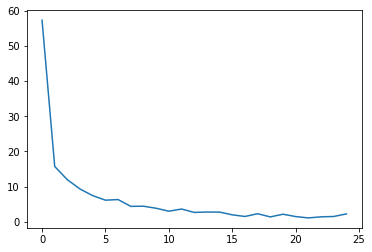

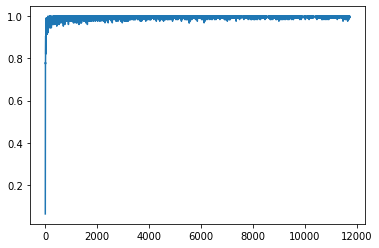

Test total loss 2.515 Test accuracy 0.992


In [3]:
if __name__ == '__main__':
    T.backends.cudnn.benchmark = True
    network = CNN(lr=0.001, batch_size=128, epochs=18)
    network._train()
    plt.plot(network.loss_history)
    plt.show()
    plt.plot(network.acc_history)
    plt.show()
    network._test()    